In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import display
import import_ipynb
from util import utils

# 环境

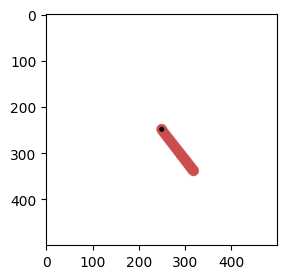

In [2]:
env = utils.PendulumEnv()
state = env.reset(seed=0)
env.show()

# 算法定义

## Qnet

In [3]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

## VAnet

In [4]:
class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q

## DQN类

In [5]:
def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (np.array(discrete_action) /
                              (action_dim - 1)) * (action_upbound -
                                                   action_lowbound)

In [6]:
class DQN:
    ''' DQN算法，包括DQN，DoubleDQN和DuelingDQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 name='DQN'):
        self.action_dim = action_dim
        if name == 'DuelingDQN':  # Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim,
                               self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,
                                      self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,
                              self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.device = device
        self.name = name
        self.max_q_value_list = []
        self.max_q_value = 0

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return [action]

    def get_max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']),
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']),
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions) # Q值
        # 下个状态的最大Q值
        if self.name == 'DoubleDQN': # DQN与Double DQN的区别
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(
                1, max_action)
        else: # DQN的情况
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
                -1, 1)
        # TD误差目标
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        # 均方误差损失函数
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()
        # 更新目标网络
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

    def play(self, env, update=False, show=False, replay_buffer=None):
        episode_return = 0
        state = env.reset()
        done = False
        while not done:
            self.max_q_value = self.get_max_q_value(
                        state) * 0.005 + self.max_q_value * 0.995  # 平滑处理
            self.max_q_value_list.append(self.max_q_value)  # 保存每个状态的最大Q值
            action = agent.take_action(state)
            action_continuous = dis_to_con(action, env,
                                           agent.action_dim)
            next_state, reward, done = env.step(action_continuous)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            episode_return += reward
            if show:
                display.clear_output(wait=True)
                env.show()
            if update:
                # 当 buffer数据的数量超过一定值后，才更新网络
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
        return episode_return 

# 初始化

In [7]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [8]:
buffer_size = 10000
batch_size = 64
minimal_size = 500
replay_buffer = utils.ReplayBuffer(buffer_size)

In [9]:
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = 11  # 将连续动作分成11个离散动作
lr = 1e-2
gamma = 0.98
epsilon = 0.01
target_update = 50
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
name = 'DQN'
# name = 'DoubleDQN'
# name = 'DuelingDQN'
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, name=name)

In [10]:
num_episodes = 200
epochs = 10

# 玩一局游戏（训练前）

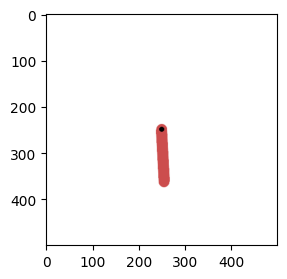

回报：-24.71569899096364


In [11]:
episode_return = agent.play(env, update=False, show=True, replay_buffer=replay_buffer)
print("回报：{}".format(episode_return))

# 算法训练

## 训练过程

In [12]:
def train(env, agent, num_episodes, epochs, replay_buffer=None):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = agent.play(env, update=True, show=False, replay_buffer=replay_buffer)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

In [13]:
return_list = train(env, agent, num_episodes, epochs, replay_buffer)

Iteration 9: 100%|█████████████████████████████████████████| 20/20 [00:36<00:00,  1.82s/it, episode=200, return=87.653]


## 训练结果

### 训练回报

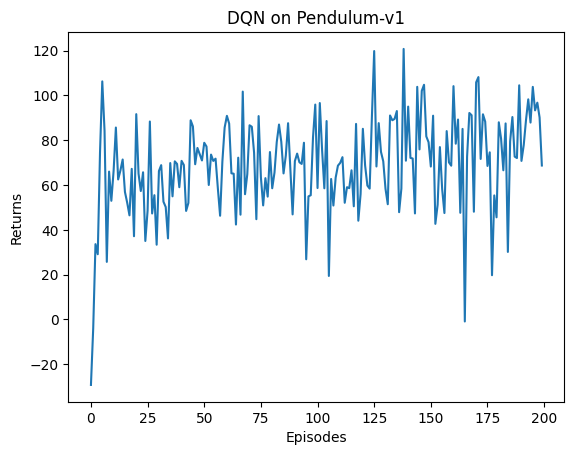

In [14]:
utils.show_return(return_list, agent, env)

### 移动平均训练回报

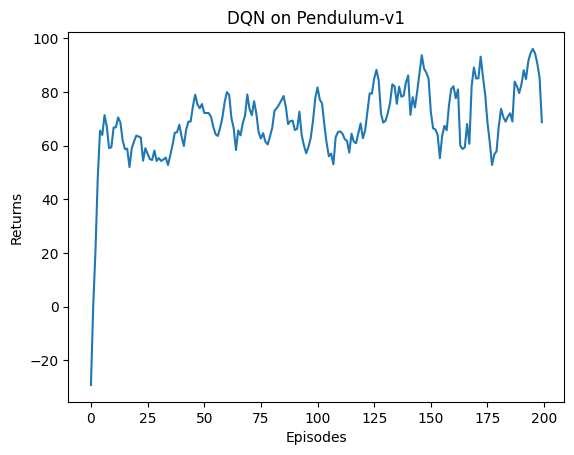

In [15]:
mv_return = utils.moving_average(return_list, 5)
utils.show_return(mv_return, agent, env)

### 最大Q值

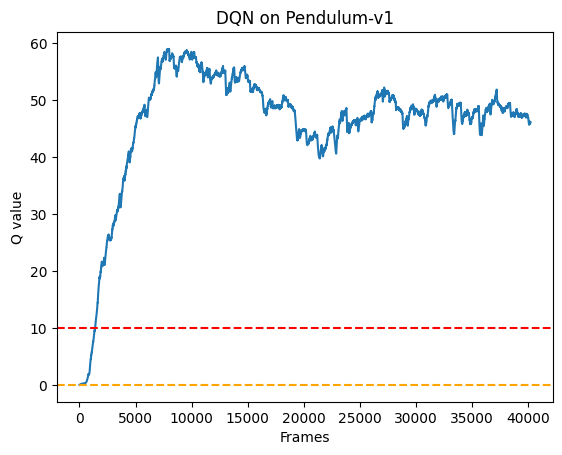

In [16]:
frames_list = list(range(len(agent.max_q_value_list)))
plt.plot(frames_list, agent.max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('{} on {}'.format(agent.name, env.name))
plt.show()

# 再玩一局游戏（训练后）

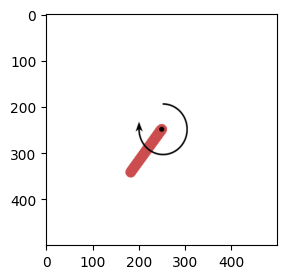

回报：11.552095500365963


In [18]:
episode_return = agent.play(env, update=False, show=True, replay_buffer=replay_buffer)
print("回报：{}".format(episode_return))